In [1]:
print('ready')

ready


In [2]:
import torch as t
from torch.nn import ReLU, SELU
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython import display
from parse_dataset import *
from rank_based import *
from icnn import ICNN, gradient_step_action, diff_params
from copy import deepcopy
from ER import *
from utils import variable

# Load and parse dataset

In [3]:
data = pd.read_csv('Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

Split train/test

In [4]:
train_idx, test_idx = split_train_test_idx(data)

List of transitions `(s,a,r,s')`

In [5]:
# transitions_train = transition_iterator(data, test_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)
transitions_train = transition_iterator(data, train_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

In [6]:
transitions_dict = {k: {
    's': values[0],
    'a': values[1],
    'r': values[2],
    's\'': values[3]   
}
 for k, values in enumerate(transitions_train)
}

# Test maximisation de Q

Ce bout de code est celui qui est au debut de `get_q_target`

In [7]:
icnn = ICNN(4,50)

In [8]:
next_state = t.cat([
    variable(np.array([50*[np.nan]])),
    variable(np.zeros((1,50)))
]).float()


next_state_ = []
good = dict()
for i, s in enumerate(next_state):
    if not np.isnan(s.data.numpy()[0]):
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)
if len(good) == 0:
    print('no good', rewards.squeeze())
else:
    next_state_ = t.cat(next_state_)
    max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    input_param = t.nn.Parameter(max_action.data)
    optimizer_for_a = t.optim.Adam([input_param], lr=1.)
    for k in range(50):
        max_action, input_param, optimizer_for_a = gradient_step_action(icnn, next_state_, max_action, input_param=input_param, optimizer=optimizer_for_a)
        if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-5:
            break

In [9]:
icnn(next_state, max_action)

Variable containing:
    nan
 0.6356
[torch.FloatTensor of size 2x1]

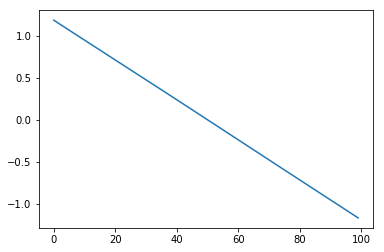

In [10]:
actions = variable(np.array([[a,0.] for a in np.arange(-100,100,2.)])).float()
Qvalues = icnn.forward(variable(t.zeros(100,50)), actions).data.numpy()
plt.plot(Qvalues)
plt.show()

In [11]:
max(Qvalues)

array([ 1.18838108], dtype=float32)

### Build neural network
The neural network is convex in $a$

$$u_0 = x$$
$$z_0 = a$$
$$u_{i+1} = \tilde{g}_i(\tilde{W}_iu_i+b_i)$$
$$z_{i+1} = g_i\left(W_i^{(z)}(z_i \cdot (W_i^{(zu)}u_i+b_i^{(z)})_+) + W_i^{(a)}(a \cdot (W_i^{(au)}u_i+b_i^{(a)})) + W_i^{(u)}u_i+b_i\right)$$
with $$W_i^{(z)}\geq 0$$


In [ ]:
icnn = ICNN(4, 50, activation=SELU())
# icnn = ICNN(4, 50, activation=ReLU())

# Train neural network

In [ ]:
q = get_experience_buffer(icnn, transitions_train)

In [ ]:
print('ready')

In [ ]:
from time import time

# SOME DEBUGING TOOLS
def logs(verbose, *message):
    if verbose:
        print(message)  

debug = False
verbose = False

# INITIALIZE SOME VARIABLES
EPOCHS = 2
batch_size = 32
learning_rate = 1e-2
gamma = 1.
losses = []
T_UPDATE_Q = 5000

# OPTIMIZER PARAMETERS
optimizer = t.optim.Adam(list(icnn.parameters()), lr=learning_rate, weight_decay=1e-5)  # weight_decay is the coefficient of the l2 regularization (to avoid overfitting)
max_steps = 10000
max_steps_a = 50

# INITIALIZE Q TARGET
prev_icnn= deepcopy(icnn)
params0 = prev_icnn.parameters()

# TRAIN
for _ in range(EPOCHS):
    for step in range(max_steps):

        # Sample batch
        states_idx = sample(q, batch_size)
        logs(verbose, *['states_idx', states_idx])

        states = t.cat([variable(transitions_dict[idx]['s']).resize(1,50) for idx in states_idx], 0).float()
        actions = t.cat([variable(transitions_dict[idx]['a']).resize(1,2) for idx in states_idx], 0).float()
        rewards = variable([transitions_dict[idx]['r'] for idx in states_idx]).float()
        next_states = t.cat([variable(transitions_dict[idx]["s'"]).resize(1,50) if transitions_dict[idx]["s'"] is not None else variable(np.array([50*[np.nan]])) for idx in states_idx]).float()
        logs(verbose, *['states', states])
        logs(verbose, *['actions', actions])
        logs(verbose, *['rewards', rewards])
        logs(verbose, *['next_states', next_states])

        # Init grad (set all of them to zero)
        optimizer.zero_grad()

        # Predictions
        Q_pred = icnn.forward(states, actions)
        logs(verbose, *['pred', Q_pred])

        # Compute target
        Q_target = get_q_target(prev_icnn, next_states, rewards, gamma=gamma, max_steps_a=max_steps_a)
        logs(verbose, *['target', Q_target])

        # Compute loss
        loss = (Q_pred.squeeze() - Q_target.squeeze())**2
        logs(verbose, *['loss', loss])

        # Update experience replay with new priorities
        update_experience(q, loss, states_idx)

        # Sum loss
        loss = t.sum(loss)

        # Monitoring
        losses.append(loss.data.numpy()[0])

        # check if parameters of prev_icnn stays frozen
        assert diff_params(params0, list(prev_icnn.parameters())) < 1e-15, diff_params(params0, list(prev_icnn.parameters()))

        # Save previous Q
        if step % T_UPDATE_Q == 0:
            prev_icnn = deepcopy(icnn)
            params0 = [p*1 for p in prev_icnn.parameters()]

        # compute gradients
        loss.backward()

        # update the weights
        params_icnn = [p*1. for p in icnn.parameters()]
        optimizer.step()
        distance_new_params = diff_params(params_icnn, list(icnn.parameters())) 
        logs(verbose, *['distance_new_params', distance_new_params])

        assert distance_new_params > 1e-5

        # keep weights positive
        icnn.proj()

        # plot
        if step % 500 == 0:
            if not debug:
                display.clear_output(wait=True)
            plt.plot(losses[-2000:])
            plt.show()

        if debug:
            y = input('Stop ?')
            display.clear_output(wait=True)
            if y == 'y':
                break